In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
import numpy as np

In [8]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega,rate = self.sc.optimal_omegad(self.A)
        self.optimal_omega = self.optimal_omega*2*np.pi
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)
        self.detuning = np.real(self.sc.H)[2,2] - self.optimal_omega

    def noise_check(self, if_plot=False):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        if if_plot:
            gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi



In [9]:
import numpy as np
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import time
import warnings

# ---------------------------------------------------------------------------
# 1. YOUR SPECIFIC FITTING FUNCTION
#    (This should be the same as before)
# ---------------------------------------------------------------------------
def fit_rate_function(time_points, population_data):
    """
    Fits the model P(t) = 0.5 * (1 + exp(-gamma * t)) to an averaged data curve.

    Returns:
        float: The single fitted rate parameter 'gamma'.
    """
    def model(t, gamma):
        return 0.5 * (1 - np.exp(-gamma * t))

    try:
        initial_guess_gamma = 1.0 / np.median(time_points)
        params, _ = curve_fit(model, time_points, population_data, p0=[initial_guess_gamma])
        return params[0]
    except (RuntimeError, ValueError):
        return np.nan

# ---------------------------------------------------------------------------
# 2. BLOCK BOOTSTRAPPING IMPLEMENTATION
# ---------------------------------------------------------------------------
def calculate_std_via_block_bootstrap(
    population_matrix,
    time_points,
    fit_func,
    num_bootstrap_samples=1000,
    n_jobs=-1
):
    """
    Calculates the standard deviation of a fitted rate using block bootstrapping.

    This method is robust against noisy individual trajectories because it always
    fits to an averaged curve.

    Args:
        population_matrix (np.ndarray): The full data matrix of shape 
                                        (num_trajectories, num_time_points).
        time_points (np.ndarray): 1D array of time points.
        fit_func (callable): The function that fits the rate to an averaged curve.
        num_bootstrap_samples (int): The number of bootstrap repetitions to perform.
        n_jobs (int): The number of CPU cores to use for parallel processing. 
                      -1 uses all available cores.

    Returns:
        tuple: (mean_of_fitted_rates, std_dev_of_fitted_rates)
    """
    num_trajectories = population_matrix.shape[0]

    # This helper function performs a single bootstrap iteration
    def bootstrap_single_iteration(iteration_seed):
        # By seeding each job with a different number, we ensure that the random
        # sampling is different for each parallel process.
        np.random.seed(iteration_seed)

        # 1. Resample with replacement from the TRAJECTORIES
        #    Create a new dataset by randomly picking rows from the original matrix.
        bootstrap_indices = np.random.randint(0, num_trajectories, size=num_trajectories)
        resampled_matrix = population_matrix[bootstrap_indices]

        # 2. Average the new dataset to get a smooth curve
        avg_resampled_population = np.mean(resampled_matrix, axis=0)

        # 3. Fit the model to this new averaged curve
        fitted_rate = fit_func(time_points, avg_resampled_population)
        
        return fitted_rate

    # --- Run all bootstrap iterations in parallel ---
    print(f"Starting {num_bootstrap_samples} block bootstrap iterations on "
          f"{n_jobs if n_jobs!=-1 else 'all available'} cores...")
    
    # Each call to bootstrap_single_iteration is an independent task
    all_fitted_rates = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_single_iteration)(i) for i in range(num_bootstrap_samples)
    )

    # --- Final Analysis ---
    # Filter out any fits that might have failed (though less likely now)
    successful_fits = [rate for rate in all_fitted_rates if not np.isnan(rate)]
    
    if len(successful_fits) < num_bootstrap_samples:
        failed_count = num_bootstrap_samples - len(successful_fits)
        warnings.warn(f"{failed_count} of {num_bootstrap_samples} bootstrap fits failed.")

    if not successful_fits:
        warnings.warn("All bootstrap fits failed. Cannot compute statistics.")
        return np.nan, np.nan

    # The mean and std of the resulting distribution of rates
    mean_of_rates = np.mean(successful_fits)
    std_dev_of_rates = np.std(successful_fits, ddof=1) # Use ddof=1 for sample std dev

    return mean_of_rates, std_dev_of_rates


In [11]:
def run_simulation_fock0(A, S0):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()
    def simulate_trajectory(i, sim, A, t_max, sample_rate, sim_time):
        sds, sop, H_control, H0 = sim.operators()
        time_points = np.linspace(0, sim_time, sim_time)
        floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
        get_projector = sim.get_projector
        floquet_ground = floquet_states[:,0]
        floquet_excited = floquet_states[:,1]
        initial_state = qt.Qobj(floquet_ground)
        projectors = get_projector(floquet_states)
        drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
        opts = {'nsteps': t_max, 'atol': 1e-11, 'rtol': 1e-11}
        
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
        H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        
        avg_values_single = np.zeros(len(time_points))
        for j, t in enumerate(time_points):
            floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
            projectors = get_projector(floquet_states)
            P10 = projectors[2]
            avg_values_single[j] = qt.expect(P10, result.states[j])
        
        return avg_values_single

    sim_time = 50000
    num_trajectories = len(sim.trajs)

    # Parallelize the simulation across all trajectories
    avg_values = Parallel(n_jobs=-1)(
        delayed(simulate_trajectory)(i, sim, A, t_max, sample_rate, sim_time) 
        for i in range(num_trajectories)
    )

    # Convert to numpy array with shape (100, sim_time)
    avg_values = np.array(avg_values)
    mean_of_rates, std_dev_of_rates = calculate_std_via_block_bootstrap(avg_values, np.linspace(0, sim_time, sim_time), fit_rate_function)
    return mean_of_rates, std_dev_of_rates


In [ ]:
A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 5)  # 5 points from 1e-6 to 1e-5

# Get avg and std for each A and S0 combination
results = {}
for A in A_values:
    results[A] = {'avg': [], 'std': []}
    for S0 in S0_values:
        avg, std = run_simulation_fock0(A, S0)
        results[A]['avg'].append(avg)
        results[A]['std'].append(std)
        print(f"A = {A/(2*np.pi)*1e3:.1f} mHz, S0 = {S0:.1e}: avg = {avg:.6f}, std = {std:.6f}")

Data saved to 'excitation0_rate_data.pkl'
A = 1.0 mHz: Log-log slope = 1.978
A = 3.0 mHz: Log-log slope = 1.982
A = 5.0 mHz: Log-log slope = 1.971


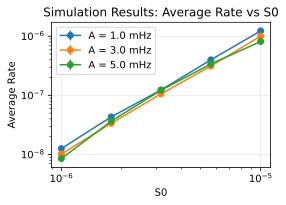

In [22]:
# Save data for replotting in another notebook
import pickle

plot_data = {
    'A_values': A_values,
    'S0_values': S0_values,
    'results': results
}

with open('excitation0_rate_data.pkl', 'wb') as f:
    pickle.dump(plot_data, f)

print("Data saved to 'excitation0_rate_data.pkl'")

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot the results from the simulation and fit log-log relationship
for A in A_values:
    avg_values = results[A]['avg']
    std_values = results[A]['std']
    
    # Plot average values with error bars on log-log scale
    ax.errorbar(S0_values, avg_values, yerr=std_values, 
                marker='o', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz')
    
    # Fit log-log relationship: log(avg_values) = slope * log(S0_values) + intercept
    log_S0 = np.log10(S0_values)
    log_avg = np.log10(avg_values)
    
    # Linear fit in log space
    slope, intercept = np.polyfit(log_S0, log_avg, 1)
    
    print(f"A = {A/(2*np.pi)*1e3:.1f} mHz: Log-log slope = {slope:.3f}")

ax.set_xlabel('S0')
ax.set_ylabel('Average Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Simulation Results: Average Rate vs S0')

plt.tight_layout()
plt.show()

In [23]:
def run_simulation_fock1(A, S0):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()
    def simulate_trajectory(i, sim, A, t_max, sample_rate, sim_time):
        sds, sop, H_control, H0 = sim.operators()
        time_points = np.linspace(0, sim_time, sim_time)
        floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
        get_projector = sim.get_projector
        floquet_ground = floquet_states[:,0]
        floquet_excited = floquet_states[:,1]
        initial_state = qt.Qobj(floquet_excited)
        projectors = get_projector(floquet_states)
        drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
        opts = {'nsteps': t_max, 'atol': 1e-11, 'rtol': 1e-11}
        
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
        H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        
        avg_values_single = np.zeros(len(time_points))
        for j, t in enumerate(time_points):
            floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
            projectors = get_projector(floquet_states)
            P11 = projectors[3]
            avg_values_single[j] = qt.expect(P11, result.states[j])
        
        return avg_values_single

    sim_time = 50000
    num_trajectories = len(sim.trajs)

    # Parallelize the simulation across all trajectories
    avg_values = Parallel(n_jobs=-1)(
        delayed(simulate_trajectory)(i, sim, A, t_max, sample_rate, sim_time) 
        for i in range(num_trajectories)
    )

    # Convert to numpy array with shape (100, sim_time)
    avg_values = np.array(avg_values)
    mean_of_rates, std_dev_of_rates = calculate_std_via_block_bootstrap(avg_values, np.linspace(0, sim_time, sim_time), fit_rate_function)
    return mean_of_rates, std_dev_of_rates


In [ ]:
A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 5)  # 5 points from 1e-6 to 1e-5

# Get avg and std for each A and S0 combination
results = {}
for A in A_values:
    results[A] = {'avg': [], 'std': []}
    for S0 in S0_values:
        avg, std = run_simulation_fock1(A, S0)
        results[A]['avg'].append(avg)
        results[A]['std'].append(std)
        print(f"A = {A/(2*np.pi)*1e3:.1f} mHz, S0 = {S0:.1e}: avg = {avg:.6f}, std = {std:.6f}")

In [ ]:
# Save data for replotting in another notebook
import pickle

plot_data = {
    'A_values': A_values,
    'S0_values': S0_values,
    'results': results
}

with open('excitation1_rate_data.pkl', 'wb') as f:
    pickle.dump(plot_data, f)

print("Data saved to 'excitation1_rate_data.pkl'")

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot the results from the simulation and fit log-log relationship
for A in A_values:
    avg_values = results[A]['avg']
    std_values = results[A]['std']
    
    # Plot average values with error bars on log-log scale
    ax.errorbar(S0_values, avg_values, yerr=std_values, 
                marker='o', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz')
    
    # Fit log-log relationship: log(avg_values) = slope * log(S0_values) + intercept
    log_S0 = np.log10(S0_values)
    log_avg = np.log10(avg_values)
    
    # Linear fit in log space
    slope, intercept = np.polyfit(log_S0, log_avg, 1)
    
    print(f"A = {A/(2*np.pi)*1e3:.1f} mHz: Log-log slope = {slope:.3f}")

ax.set_xlabel('S0')
ax.set_ylabel('Average Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Simulation Results: Average Rate vs S0')

plt.tight_layout()
plt.show()